# Склеивание панорам

Из нескольких кадров, снятых из одной точки, но под разными углами, нужно составить одну панораму.
Для этого мы будем использовать дескрипторы особых точек [ORB](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.370.4395&rep=rep1&type=pdf) и алгоритм оценки параметров модели [RANSAC](https://ru.wikipedia.org/wiki/RANSAC).

На вход алгоритм получает N кадров.

1. Находим особые точки и их дескрипторы на всех кадрах панорамы с помощью алгоритма ORB 
1. Получаем преобразование между соседними кадрами с помощью алгоритма Ransac 
1. Получаем преобразование всех кадров на плоскость центрального кадра 
1. Преобразовываем кадры так, чтобы они оказались в плоскости центрального кадра и изображаем на одном изображении. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io

## 0. Загрузка кадров

В папке jpeg лежат подпапки 1, 2, 3, ...

Каждая подпапка - набор кадров, которые вам предстоит склеить. Давайте откроем одну из папок и увидим, что у нее внутри.

In [2]:
FIGSIZE = (15, 10)
COLUMNS = 3
ROWS = 3

def plot_collage(imgs, columns=COLUMNS, rows=ROWS, figsize=FIGSIZE, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
        plt.axis('off')
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i-1], interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

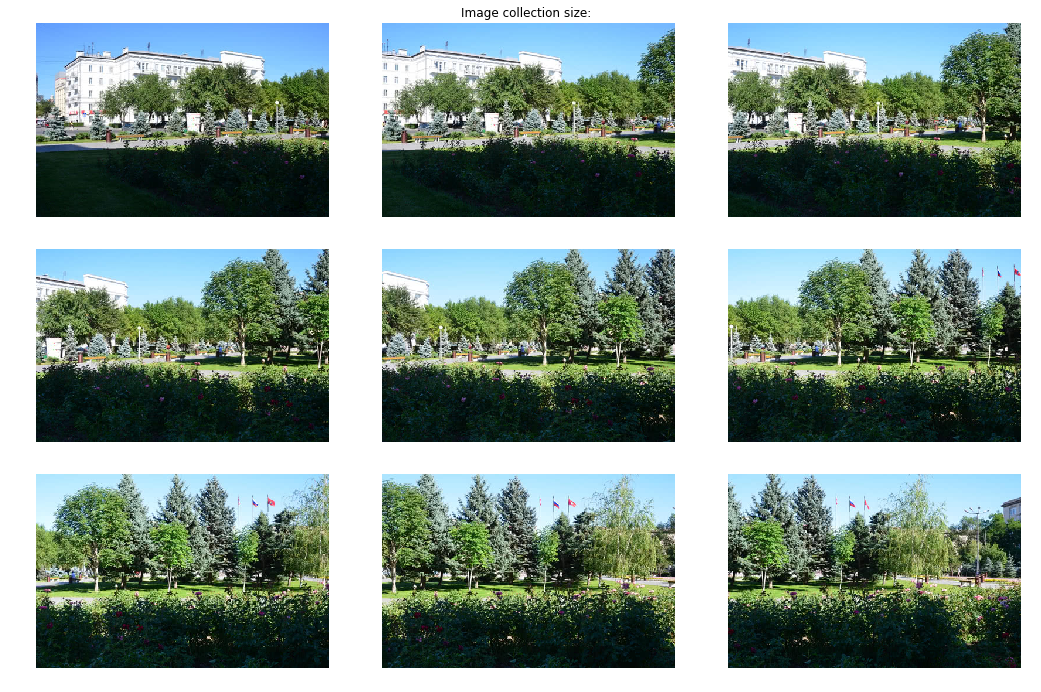

In [3]:
pano_image_collection = io.ImageCollection('jpeg/lowres/8_*.jpg', load_func=lambda f: io.imread(f).astype(np.float32) / 255)
plot_collage(pano_image_collection, title="Image collection size: ".format(len(pano_image_collection)))

## 1. Выделение ключевых точек

Для начала найдем ключевые точки на каждом кадре.
Если на последующих этапах качество совмещения будет недостаточным, настроим параметры алгоритма ORB.

In [4]:
from skimage.feature import ORB
from skimage.color import rgb2gray

def find_orb(img, n_keypoints=2000, **args):
    """Найти ключевые точки и их дескрипторы на изображении.
    
    img (np.array WxHx3) трехканальное изображение
    n_keypoints (int) число ключевых точек, которые нужно найти на изображении
    **kwargs (dict) остальные параметры, передаются в ORB без изменений
    
    Return: tuple (2,) координаты и дескриторы ключевых точек
    """
    
    gray_image = rgb2gray(img)
    descriptor_extractor = ORB(n_keypoints=n_keypoints)
    
    descriptor_extractor.detect_and_extract(gray_image)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    return keypoints, descriptors

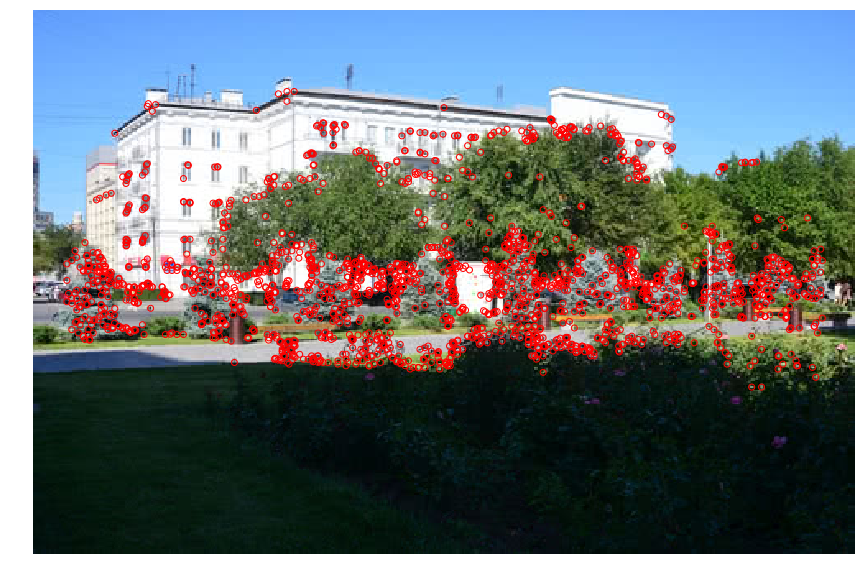

In [5]:
# Выводим первое изображение и ключевые точки на нем
img = pano_image_collection[0]
plt.figure(figsize=FIGSIZE)
plt.imshow(img)
plt.axis('off')

keypoints, descriptors = find_orb(img)

plt.scatter(keypoints[:, 1], keypoints[:, 0], facecolors='none', edgecolors='r')

## 2. Получаем преобразование между соседними кадрами с помощью алгоритма Ransac

На основе функции извлечения ключевых точек построим алгоритм поиска соответствий между соседними кадрами.

Можно предполагать, что изображения размещены в порядке съемки слева направо.

In [6]:
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform
from skimage.measure import ransac

# Будем использовать дальше
DEFAULT_TRANSFORM = ProjectiveTransform

def find_robust_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors,
                          return_matches=False,
                          model_class=DEFAULT_TRANSFORM, min_samples=4, residual_threshold=1, 
                          max_trials=5000, **kwargs):
    """Найти соответствие между двумя кадрами панорамы.
    
    src_keypoints, dest_keypoints - координаты ключевых точек
    src_descriptors, dest_descriptors - дескрипторы ключевых точек
    model_class, min_samples, residual_threshold, **kwargs - параметры алгоритма ransac
     - model_class - используемая модель преобразования плоскости
     - min_samples - необходимое число точек для построения преобразования.
                     Чем сложнее модель, тем больше нужно точек.
                     Про конкретную модель можно прочитать в документации.
     - residual_threshold - какое расстояние в пикселях между точками считать совпадением.
     - max_trials - какое количество попыток можно сделать, прежде чем остановиться.
                    Чем больше точек мы хотим сопоставить, тем больше должно быть это число.
     - **kwargs - Остальные параметры
     
    
    Return: tuple (2, )
    result[0]: преобразование, переводящее 1 кадр в плоскость второго
    result[1]: сопоставление точек (исключая выбросы)
    """
    
    matches = match_descriptors(src_descriptors, dest_descriptors)
    model_robust, inliers = ransac((np.array(src_keypoints)[matches[:, 0]], 
                                    np.array(dest_keypoints)[matches[:, 1]]), model_class, min_samples,
                                    residual_threshold, max_trials=max_trials)
    
    return model_robust, matches[inliers]

[[ 9.98279990e-01  2.60336460e-02 -7.11087667e+00]
 [-9.06252691e-03  1.03434796e+00 -8.98578006e+01]
 [-1.41212109e-05  1.66449164e-04  9.54456442e-01]]


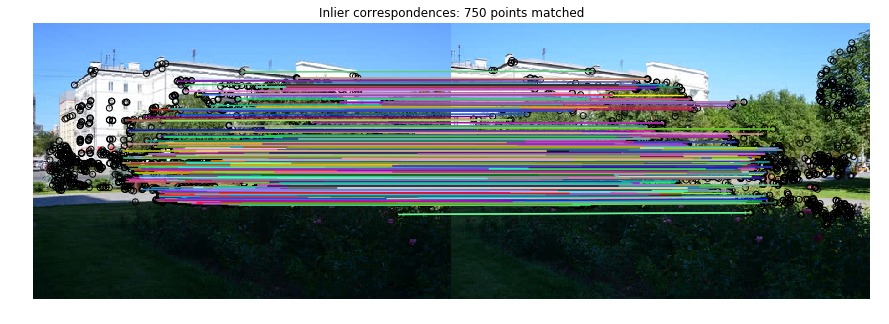

In [7]:
# Проверка работы функции поиска преобразований соседних кадров
from skimage.feature import plot_matches

src, dest = pano_image_collection[0], pano_image_collection[1]

src_keypoints, src_descriptors = find_orb(src)
dest_keypoints, dest_descriptors = find_orb(dest)

robust_transform, matches = find_robust_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

print(robust_transform.params)

# Visualize the results.
plt.figure(figsize=FIGSIZE)
ax = plt.axes()
ax.axis("off")
ax.set_title("Inlier correspondences: {} points matched".format(len(matches)))

plot_matches(ax, src, dest, src_keypoints, dest_keypoints, matches)

plt.show()

In [8]:
# Найдем попарные преобразования между каждыми кадрами и сохраним в массив diff_warps
keypoints, descriptors = zip(*(find_orb(img) for img in pano_image_collection))
forward_transforms = tuple(find_robust_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc 
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]
/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py:555: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 1] /= dst[:, 2]
/usr/local/lib/python3.5/dist-packages/skimage/measure/fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py:554: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 0] /= dst[:, 2]
/usr/local/lib/python3.5/dist-packages/skimage/transform/_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]


## 3. Получаем преобразование всех кадров на плоскость центрального кадра

Так как на крайних кадрах может не быть одинаковых объектов, нам придется сначала искать преобразование между соседними кадрами, а потом строить преобразование, которое каждый кадр приведет на плоскость среднего кадра.

In [9]:
from numpy.linalg import inv

def find_simple_center_warps(forward_transforms):
    """Найдем преобразование, которое каждый кадр коллекции приведет на плоскость среднего кадра.
    diff_warps: Tuple[N] - попарные преобразования кадров
    return List[N + 1] - преобразования каждого кадра в плоскость центрального кадра
    """
    image_count = len(forward_transforms) + 1 # сколько всего изображений
    center_index = (image_count - 1) // 2 # какой индекс у центральной картинки
    
    result = [None] * image_count
    result[center_index] = DEFAULT_TRANSFORM()

    for index in range(center_index - 1, -1, -1):        # pass left
        result[index] = result[index + 1] + forward_transforms[index][0]

    for index in range(center_index + 1, image_count):   # pass right
        inv_transformation = DEFAULT_TRANSFORM(inv(forward_transforms[index-1][0].params))
        result[index] = result[index - 1] + inv_transformation

    return tuple(result)

Text(0.5, 1.0, 'Border visualization')

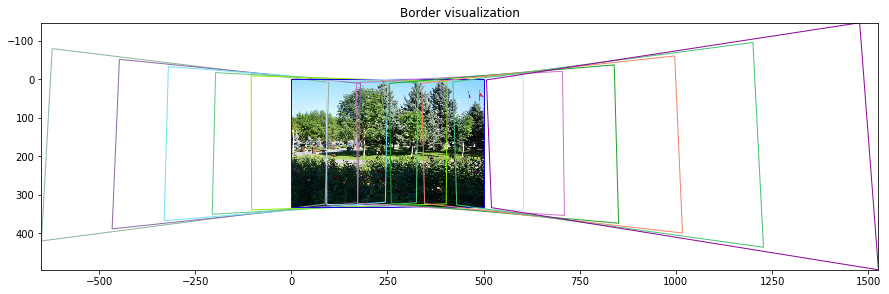

In [10]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

np.random.seed(0)
plt.figure(figsize=FIGSIZE)
ax = plt.axes()

def get_corners(image_collection, center_warps):
    """Получаем координаты углов каждого кадра после преобразований."""
    for img, transform in zip(pano_image_collection, center_warps):
        height, width, _ = img.shape
        corners = np.array([[0, 0],
                            [height, 0],
                            [height, width],
                            [0, width]
                           ])

        yield transform(corners)[:, ::-1]

def get_min_max_coords(corners):
    """Получаем минимальный и максимальные координаты углов."""
    corners = np.concatenate(corners)
    return corners.min(axis=0), corners.max(axis=0)  

# Проверка
simple_center_warps = find_simple_center_warps(forward_transforms)

corners = tuple(get_corners(pano_image_collection, simple_center_warps))

for coords in corners:
    ax.add_patch(Polygon(coords, closed=True, fill=False, color=np.random.rand(3)))

min_coords, max_coords = get_min_max_coords(corners)
plt.xlim(min_coords[0], max_coords[0])
plt.ylim(max_coords[1], min_coords[1])

center_index = (len(pano_image_collection) - 1) // 2
plt.imshow(pano_image_collection[center_index])

plt.title('Border visualization')

Однако, как мы видим, часть изображения ушла в отрицательную часть плоскости, а часть вышла за рамки центрального изображения. Если мы сейчас начнем соединять изображения, то все за рамками центрального изображения будет обрезано.

Нам нужно:
- Получить такие преобразования, которые отправляли бы изображение в положительную четверть.
- Рассчитать размер финального изображения

In [11]:
def get_final_center_warps(image_collection, simple_center_warps):
    
    corners = tuple(get_corners(pano_image_collection, simple_center_warps))
    min_coords, max_coords = get_min_max_coords(corners)
    x_shape = max_coords[0] - min_coords[0]
    y_shape = max_coords[1] - min_coords[1]

    translation_matrix = np.array([[1, 0, -min_coords[1]], # матрица переноса
                                   [0, 1, -min_coords[0]],
                                   [0, 0, 1]])             
    
    for index in range(len(simple_center_warps)):
        simple_center_warps[index].params = np.dot(translation_matrix, simple_center_warps[index].params)
    
    return simple_center_warps, (y_shape, x_shape)

Text(0.5, 1.0, 'Border visualization')

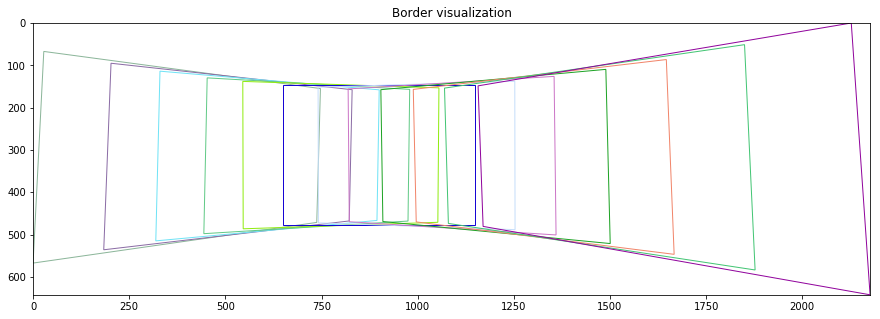

In [12]:
np.random.seed(0)
plt.figure(figsize=(15, 5))
ax = plt.axes()

# Проверка
final_center_warps, output_shape = get_final_center_warps(pano_image_collection, simple_center_warps)
# corners = tuple(get_corners(pano_image_collection, final_center_warps))
corners = tuple(get_corners(pano_image_collection, final_center_warps))

for coords in corners:
    ax.add_patch(Polygon(coords, closed=True, fill=False, color=np.random.rand(3)))

plt.xlim(0, output_shape[1])
plt.ylim(output_shape[0], 0)

plt.title('Border visualization')

## 4. Преобразовываем кадры так, чтобы они оказались в плоскости центрального кадра и соединяем на одном изображении
Теперь пришло время слить все изображения в одну панораму.

Для этого реализуем функцию слияния двух фотографий: на вход получаем новый кадр и его маску, а также результат и его маску. Обновляем результат и маску.

Нужно иметь в виду, что мы поворачиваем матрицу преобразования, т.к. она рассчитывается в координатах xy, а работа с изображениями идет в координатах row:col (yx).

In [18]:
from skimage.transform import warp

def rotate_transform_matrix(transform):
    """Сделаем так, чтобы трансформация считалась в координатах row:col."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)] 
    return type(transform)(matrix) 

def warp_image(image, transform, output_shape):
    """Применить преобразование к изображению и вернуть преобразованное изображение и маску.
    
    image: изображение для преобразования
    transform: преобразование
    output_shape: размер результата
    
    return: tuple (2, )
        np.array (h, w, 3) преобразованное изображение
        np.array (h, w) маска        
    """
    transform = rotate_transform_matrix(transform)
    inv_transform = type(transform)(inv(transform.params))
    warped = warp(image, inv_transform, output_shape=output_shape)
    mask = warped.sum(axis=2).astype(np.bool) ???
    return warped, mask
    
def navy_merge_pano(image_collection, final_center_warps, output_shape):
    """Склеим панораму из нескольких изображений.
    
    image_collection: набор изображений для склеивания
    final_center_warps: преобразования, которые переводят все кадры на плоскость центрального кадра
    output_shape: размер панорамы
    
    return: np.array (*output_shape, 3) изображение, на котором совмещены все кадры.
    """
    output_shape = np.array(output_shape).astype(int)
    pano = np.zeros((*output_shape, 3), dtype=np.float64)
    mask = np.zeros(output_shape)
    for img, transform in zip(image_collection, final_center_warps):
        warped, warp_mask = warp_image(img, transform, output_shape)
        warp_mask = np.logical_and(warp_mask, np.logical_not(mask)) ???
        pano += warped * np.tile(warp_mask, 3).reshape((*output_shape, 3), order='F') ???
        mask = np.logical_or(mask, warp_mask) ???
    
    return pano

(-0.5, 2175.5, 641.5, -0.5)

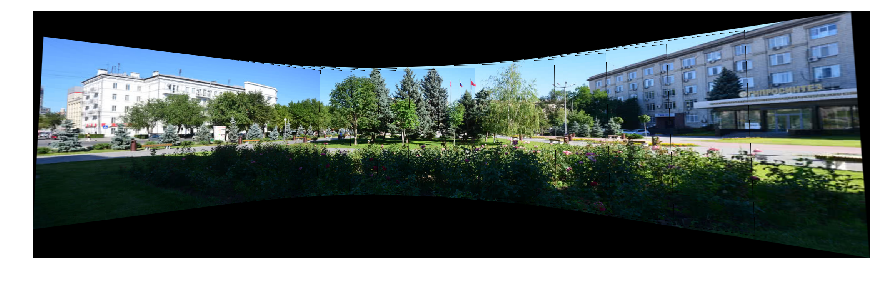

In [19]:
plt.figure(figsize=FIGSIZE)

result = navy_merge_pano(pano_image_collection, final_center_warps, output_shape)
plt.imshow(result)
plt.axis('off')